# Analysere COVID-19-artikler

I denne oppgaven skal vi fortsette med temaet COVID-pandemien og fokusere på å behandle vitenskapelige artikler om emnet. Det finnes [CORD-19-datasettet](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) med mer enn 7000 artikler (på tidspunktet for skriving) om COVID, tilgjengelig med metadata og sammendrag (og for omtrent halvparten av dem er også fulltekst tilgjengelig).

Et fullstendig eksempel på hvordan man analyserer dette datasettet ved hjelp av den kognitive tjenesten [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) er beskrevet [i dette blogginnlegget](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). Vi skal diskutere en forenklet versjon av denne analysen.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Hente dataene

Først må vi hente metadataene for CORD-artiklene som vi skal jobbe med.

**MERK**: Vi inkluderer ikke en kopi av datasettet som en del av dette repositoriet. Du må først laste ned [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv)-filen fra [dette datasettet på Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Registrering hos Kaggle kan være nødvendig. Du kan også laste ned datasettet uten registrering [herfra](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), men det vil inkludere alle fulltekster i tillegg til metadatafilen.

Vi vil forsøke å hente dataene direkte fra en nettbasert kilde, men hvis det mislykkes, må du laste ned dataene som beskrevet ovenfor. Det kan også være lurt å laste ned dataene hvis du planlegger å eksperimentere videre med dem, for å spare ventetid.

> **MERK** at datasettet er ganske stort, rundt 1 GB i størrelse, og følgende kodelinje kan ta lang tid å fullføre! (~5 minutter)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Vi skal nå konvertere kolonnen for publiseringsdato til `datetime`, og plotte histogrammet for å se rekkevidden av publiseringsdatoer.


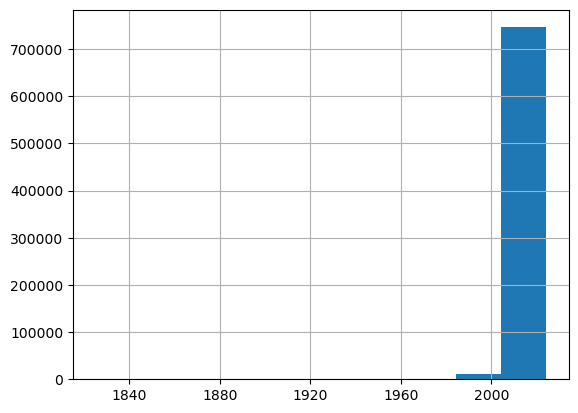

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Strukturert datauttrekk

La oss se hvilken type informasjon vi enkelt kan hente ut fra sammendrag. En ting vi kanskje er interessert i, er å se hvilke behandlingsstrategier som finnes, og hvordan de har utviklet seg over tid. For å begynne kan vi manuelt sette sammen en liste over mulige medisiner som brukes til å behandle COVID, samt en liste over diagnoser. Deretter går vi gjennom dem og søker etter tilsvarende termer i sammendragene av artikler.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Vi har lagt til en rekke kolonner i vår dataframe som inneholder antall ganger en gitt medisin/diagnose er til stede i sammendraget.

> **Merk** at vi legger til et mellomrom i begynnelsen av ordet når vi søker etter en delstreng. Hvis vi ikke gjør det, kan vi få feil resultater, fordi *klorokin* også ville bli funnet inne i delstrengen *hydroksyklorokin*. I tillegg tvinger vi konvertering av kolonnen med sammendrag til `str` for å unngå en feil - prøv å fjerne `str` og se hva som skjer.

For å gjøre det enklere å jobbe med dataene, kan vi trekke ut en delramme som kun inneholder medisinantall, og beregne det akkumulerte antallet forekomster. Dette gir oss den mest populære medisinen:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

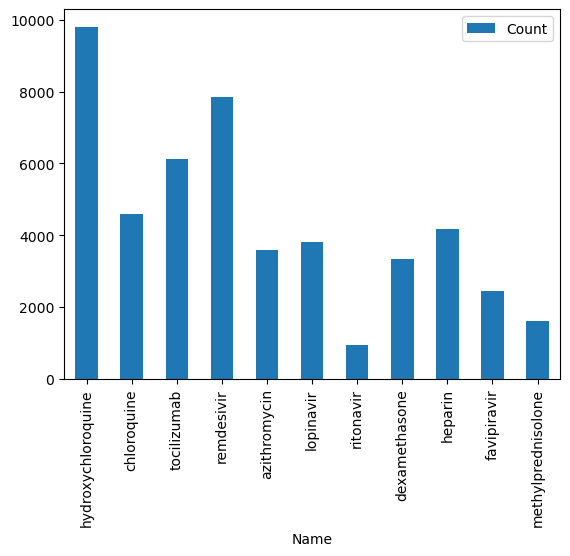

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Ser etter trender i behandlingsstrategi

I eksempelet ovenfor har vi `sum`mert alle verdier, men vi kan også gjøre det samme på månedlig basis:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

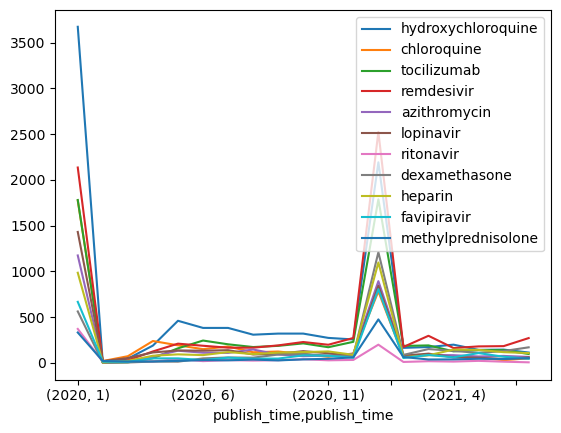

In [152]:
dfmt.plot()
plt.show()

En interessant observasjon er at vi har store topper på to tidspunkter: januar 2020 og januar 2021. Dette skyldes at noen artikler ikke har en klart spesifisert publikasjonsdato, og de er derfor angitt som januar i det respektive året.

For å få mer mening ut av dataene, la oss visualisere bare noen få medisiner. Vi vil også "slette" dataene for januar og erstatte dem med en slags gjennomsnittsverdi, for å lage et penere diagram:


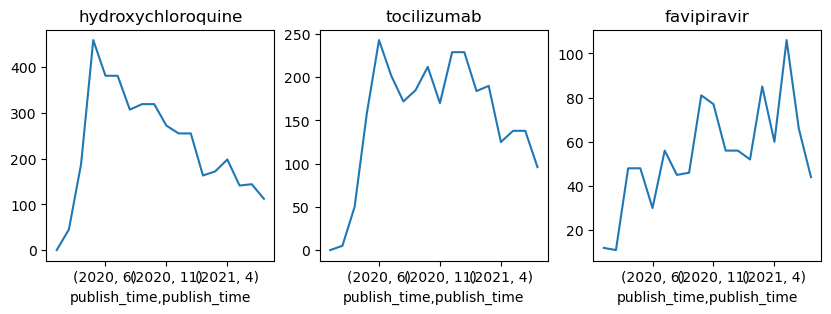

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

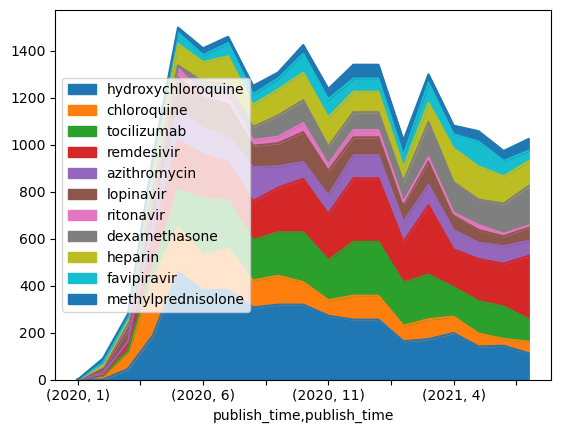

In [154]:
dfmt.plot.area()
plt.show()

Enda videre kan vi beregne relativ popularitet i prosent:


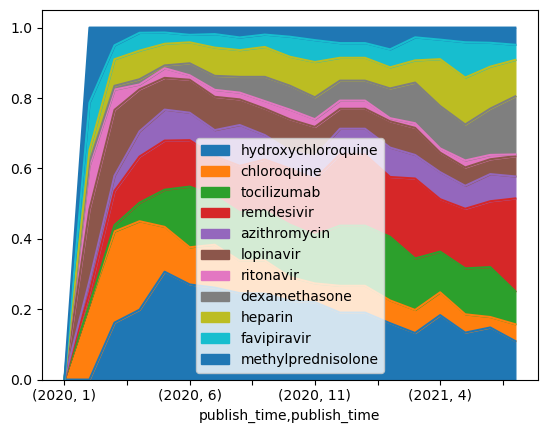

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Beregning av samsvar mellom medisin og diagnose

En av de mest interessante sammenhengene vi kan undersøke, er hvordan ulike diagnoser behandles med forskjellige medisiner. For å visualisere dette, må vi beregne et **samsvarsfrekvenskart**, som viser hvor mange ganger to termer nevnes i samme artikkel.

Et slikt kart er i hovedsak en 2D-matrise, som best representeres av en **numpy array**. Vi vil beregne dette kartet ved å gå gjennom alle sammendragene og merke entiteter som forekommer der:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

En av måtene å visualisere denne matrisen på er å tegne et **varmekart**:


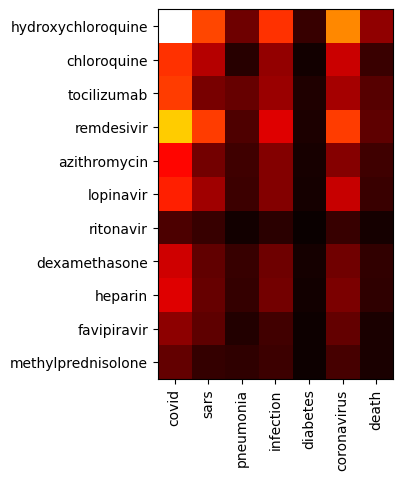

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

Men enda bedre visualisering kan oppnås ved å bruke et såkalt **Sankey**-diagram! `matplotlib` har ikke innebygd støtte for denne diagramtypen, så vi må bruke [Plotly](https://plotly.com/python/) som beskrevet [i denne veiledningen](https://plotly.com/python/sankey-diagram/).

For å lage et Sankey-diagram med Plotly, må vi bygge følgende lister:
* Listen `all_nodes` som inneholder alle noder i grafen, inkludert både medisiner og diagnoser
* Lister over kilde- og målindekser - disse listene viser hvilke noder som går til venstre, og hvilke som går til høyre i diagrammet
* En liste over alle koblinger, der hver kobling består av:
   - Kildeindeks i `all_nodes`-arrayet
   - Målindeks
   - Verdi som indikerer styrken på koblingen. Dette er nøyaktig verdien fra vår samforekomstmatrise.
   - Eventuelt farge på koblingen. Vi vil lage en mulighet for å fremheve noen av begrepene for tydelighet

Generisk kode for å tegne et Sankey-diagram er strukturert som en egen `sankey`-funksjon, som tar to lister (kilde- og mål-kategorier) og en samforekomstmatrise. Den lar oss også spesifisere en terskel og utelate alle koblinger som er svakere enn denne terskelen - dette gjør diagrammet litt mindre komplekst.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Konklusjon

Du har sett at vi kan bruke ganske enkle metoder for å hente ut informasjon fra ustrukturerte datakilder, som tekst. I dette eksempelet har vi brukt en eksisterende liste over medisiner, men det ville vært mye mer kraftfullt å bruke teknikker innen naturlig språkprosessering (NLP) for å utføre enhetsuttrekk fra tekst. I [denne bloggposten](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) beskriver vi hvordan man kan bruke skytjenester for enhetsuttrekk. Et annet alternativ er å bruke Python NLP-biblioteker som [NLTK](https://www.nltk.org/) – en tilnærming for å hente ut informasjon fra tekst ved hjelp av NLTK er beskrevet [her](https://www.nltk.org/book/ch07.html).


## Utfordring

Fortsett å utforske COVID-papirdataene langs følgende linjer:

1. Bygg en samforekomstmatrise for ulike medisiner, og se hvilke medisiner som ofte forekommer sammen (dvs. nevnt i ett abstrakt). Du kan modifisere koden for å bygge samforekomstmatrise for medisiner og diagnoser.
1. Visualiser denne matrisen ved hjelp av et varmekart.
1. Som et ekstra mål kan du visualisere samforekomsten av medisiner ved hjelp av [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram). [Dette biblioteket](https://pypi.org/project/chord/) kan hjelpe deg med å tegne et chord diagram.
1. Som et annet ekstra mål, prøv å trekke ut doseringer av ulike medisiner (slik som **400mg** i *ta 400mg klorokin daglig*) ved hjelp av regulære uttrykk, og bygg en dataframe som viser ulike doseringer for ulike medisiner. **Merk**: vurder numeriske verdier som er i nær tekstlig tilknytning til medisinens navn.



---

**Ansvarsfraskrivelse**:  
Dette dokumentet er oversatt ved hjelp av AI-oversettelsestjenesten [Co-op Translator](https://github.com/Azure/co-op-translator). Selv om vi tilstreber nøyaktighet, vennligst vær oppmerksom på at automatiske oversettelser kan inneholde feil eller unøyaktigheter. Det originale dokumentet på sitt opprinnelige språk bør anses som den autoritative kilden. For kritisk informasjon anbefales profesjonell menneskelig oversettelse. Vi er ikke ansvarlige for eventuelle misforståelser eller feiltolkninger som oppstår ved bruk av denne oversettelsen.
